# Small demo of goodies from explained.ai

There are a number of useful machine-learning-related articles at [explained.ai](https://explained.ai/), but this notebook demonstrates three of the visualization libraries that I built.  (Note: some of the SVG images below don't show up when viewing on github; run this notebook again.)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/website-explained.ai/blob/master/notebooks/demo.ipynb)

In [2]:
! pip install -q torch
! pip install -q numpy
! pip install -q scikit-learn

! pip install -q tensor-sensor
! pip install -q dtreeviz
! pip install -q lolviz

## TensorSensor

One of the biggest challenges when writing code to implement deep learning networks is getting all of the tensor (matrix and vector) dimensions to line up properly, even when using predefined network layers. This article describes a new library called TensorSensor that clarifies exceptions by augmenting messages and visualizing Python code to indicate the shape of tensor variables. It works with JAX, Tensorflow, PyTorch, and Numpy, as well as higher-level libraries like Keras and fastai. 

* [Clarifying exceptions and visualizing tensor operations in deep learning code](https://explained.ai/tensor-sensor/index.html)
* [Library code](https://github.com/parrt/tensor-sensor)

Here we have a (PyTorch) recurrence relation to update a hidden state vector  where one of the matrices has the dimensions flipped:

In [3]:
import torch

n = 200         # number of instances
d = 764         # number of instance features
nhidden = 256

Whh = torch.eye(nhidden, nhidden)   # Identity matrix
Uxh = torch.randn(d, nhidden)
bh  = torch.zeros(nhidden, 1)
h = torch.randn(nhidden, 1)         # fake previous hidden state h
r = torch.randn(nhidden, 1)         # fake this computation
X = torch.rand(n,d)                 # fake input

h = torch.tanh(Whh @ (r*h) + Uxh @ X.T + bh) # EXCEPTION

RuntimeError: mat1 and mat2 shapes cannot be multiplied (764x256 and 764x200)

From that message, it's unclear which operator and operands are the problem. 

Using a simple `with` block, TensorSensor gives us not only an augmented error message (`Cause: ...`) but also a visualization that makes it much easier to identify the mismatched dimensions:

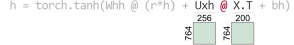

RuntimeError: mat1 and mat2 shapes cannot be multiplied (764x256 and 764x200)
Cause: @ on tensor operand Uxh w/shape [764, 256] and operand X.T w/shape [764, 200]

In [4]:
import tsensor

with tsensor.clarify():
    h = torch.tanh(Whh @ (r*h) + Uxh @ X.T + bh)

We can also visualize the dimensions of correct code (on Colab we get a `PYDEV DEBUGGER WARNING:` due to `sys.settrace` used by `explain()` but I'm not sure why):

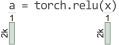

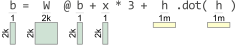

In [5]:
W = torch.rand(size=(2000,2000))
b = torch.rand(size=(2000,1))
h = torch.rand(size=(1_000_000,))
x = torch.rand(size=(2000,1))

with tsensor.explain():
    a = torch.relu(x)
    b = W @ b + x * 3 + h.dot(h)

Sometimes it's also useful to see the dimensions of all sub expressions:

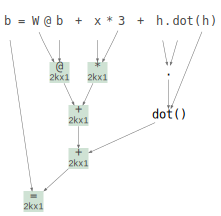

In [6]:
tsensor.astviz("b = W @ b + x * 3 + h.dot(h)")

## DTreeViz

See [How to visualize decision trees](https://explained.ai/decision-tree-viz/index.html).

Decision trees are the fundamental building block of gradient boosting machines and Random Forests(tm), probably the two most popular machine learning models for structured data. Visualizing decision trees is a tremendous aid when learning how these models work and when interpreting models. Unfortunately, current visualization packages are rudimentary and not immediately helpful to the novice. For example, we couldn't find a library that visualizes how decision nodes split up the feature space. So, we've created a general package called dtreeviz for scikit-learn decision tree visualization and model interpretation.

In [7]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, load_breast_cancer, load_diabetes
import matplotlib.pyplot as plt
from dtreeviz.trees import *

Here's an example using the toy wine classification data set.  We pick a random training record and run down the tree to demonstrate the path to the prediction node:

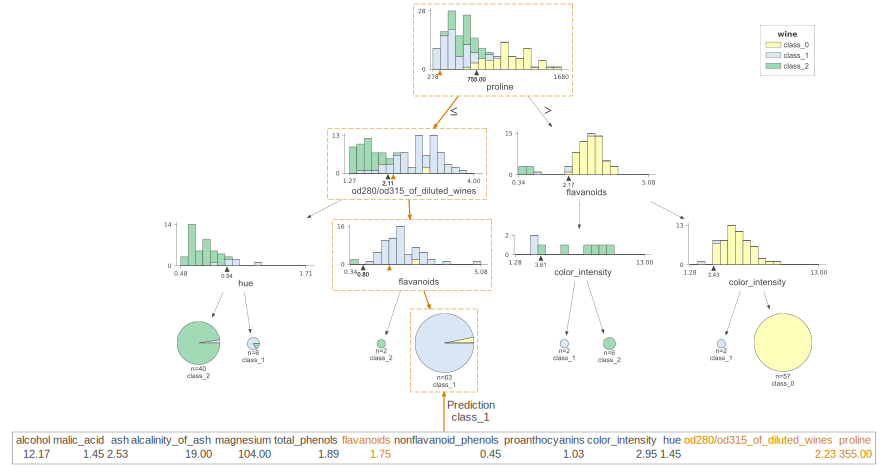

In [8]:
wine = load_wine()

clf = tree.DecisionTreeClassifier(max_depth=3)
clf.fit(wine.data, wine.target)

x = wine.data[np.random.randint(0, len(wine.data)), :]

dtreeviz(clf, wine.data, wine.target,
         target_name='wine', feature_names=wine.feature_names,
         class_names=list(wine.target_names),
         X=x)

Here is a regressor tree using the diabetes toy data set:

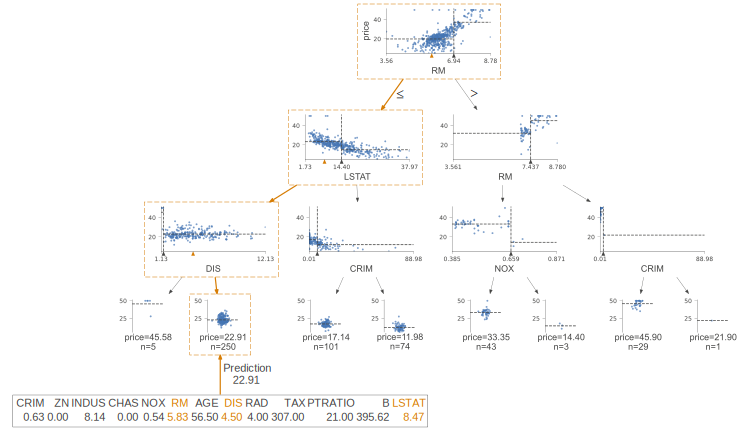

In [9]:
boston = load_boston()

regr = tree.DecisionTreeRegressor(max_depth=3)
regr.fit(boston.data, boston.target)

x = boston.data[np.random.randint(0, len(boston.data)), :]

dtreeviz(regr, boston.data, boston.target,
         target_name='price', feature_names=boston.feature_names,
         X=x)

Here's what the standard decision tree visualizations look like:

<img src="figures/scikit-dtree.png" width="250">

## LOLViz

I needed a library to draw data structures and explain function call stacks to students, so I created [lolviz](https://github.com/parrt/lolviz). It can also be used for debugging data structures, such as decision trees or graphs.

This requires the installation of DOT (graphviz), which is easiest to install on a Mac, but is already installed on COLAB:

In [10]:
# ! brew install -q graphviz    # Needed on a Mac
! pip install -q lolviz

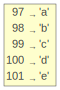

In [11]:
from lolviz import *

d = dict([(c,chr(c)) for c in range(ord('a'),ord('f'))])
objviz(d)

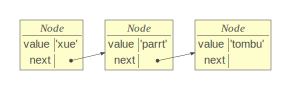

In [12]:
class Node:
    def __init__(self, value, next=None):
        self.value = value
        self.next = next

head = Node('tombu')
head = Node('parrt', head)
head = Node("xue", head)
objviz(head)

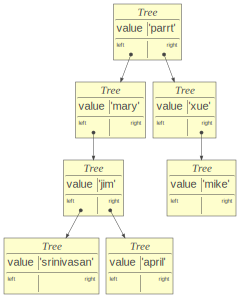

In [13]:
class Tree:
    def __init__(self, value, left=None, right=None):
        self.value = value
        self.left = left
        self.right = right
        
root = Tree('parrt',
            Tree('mary',
                 Tree('jim',
                      Tree('srinivasan'),
                      Tree('april'))),
            Tree('xue',None,Tree('mike')))

treeviz(root)

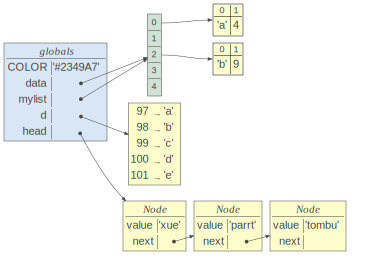

In [14]:
data = [None for i in range(5)]
data[0] = ('a',4)
data[2] = ('b',9)

mylist = data # an alias

COLOR = '#2349A7'
callsviz(varnames=['head', 'data', 'COLOR', 'd', 'mylist'])